In [16]:
from msresist.validations import preprocess_ebdt_mcf7
from msresist.clustering import MassSpecClustering
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
# Import signaling data
x = preprocess_ebdt_mcf7()
d = x.select_dtypes(include=[float]).T
i = x.select_dtypes(include=[object])

# Fit DDMC and find centers
model = MassSpecClustering(i, ncl=20, SeqWeight=5, distance_method="Binomial").fit(d)
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.n_components) + 1
centers.insert(0, "Inhibitor", x.columns[3:])
centers["Inhibitor"] = [s.split(".")[1].split(".")[0] for s in centers["Inhibitor"]]

# PCA AKT
AKTi = ["Torin1", "HS173", "GDC0941", "Ku0063794", "AZ20", "MK2206", "AZD5363", "GDC0068", "AZD6738", "AT13148", "Edelfosine", "GF109203X", "AZD8055"]
centers["AKTi"] = [drug in AKTi for drug in centers["Inhibitor"]]

In [32]:
def pca_dfs(scores, loadings, df, n_components, sIDX, lIDX):
    """ build PCA scores and loadings data frames. """
    dScor = pd.DataFrame()
    dLoad = pd.DataFrame()
    for i in range(n_components):
        cpca = "PC" + str(i + 1)
        dScor[cpca] = scores[:, i]
        dLoad[cpca] = loadings[i, :]

    for j in sIDX:
        dScor[j] = list(df[j])
    dLoad[lIDX] = df.select_dtypes(include=["float64"]).columns
    return dScor, dLoad


def plotPCA(ax, d, n_components, scores_ind, loadings_ind, hue_scores=None, style_scores=None, pvals=None, style_load=None, legendOut=False):
    """ Plot PCA scores and loadings. """
    pp = PCA(n_components=n_components)
    dScor_ = pp.fit_transform(d.select_dtypes(include=["float64"]))
    dLoad_ = pp.components_
    dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, d, n_components, scores_ind, loadings_ind)
    varExp = np.round(pp.explained_variance_ratio_, 2)

    # Scores
    sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue=hue_scores, style=style_scores, ax=ax[0], **{"linewidth": 0.5, "edgecolor": "k"})
    ax[0].set_title("PCA Scores")
    ax[0].set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=10)
    ax[0].set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=10)
    ax[0].legend(prop={'size': 8})
    if legendOut:
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, prop={'size': 8})

    # Loadings
    if isinstance(pvals, np.ndarray):
        dLoad_["p-value"] = pvals
        sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="p-value", style=style_load, ax=ax[1], **{"linewidth": 0.5, "edgecolor": "k"})
    else:
        sns.scatterplot(x="PC1", y="PC2", data=dLoad_, style=style_load, ax=ax[1], **{"linewidth": 0.5, "edgecolor": "k"})

    ax[1].set_title("PCA Loadings")
    ax[1].set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=10)
    ax[1].set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=10)
    ax[1].legend(prop={'size': 8})
    for j, txt in enumerate(dLoad_[loadings_ind]):
        ax[1].annotate(txt, (dLoad_["PC1"][j] + 0.001, dLoad_["PC2"][j] + 0.001), fontsize=10)

ValueError: could not convert string to float: 'AZD6482'

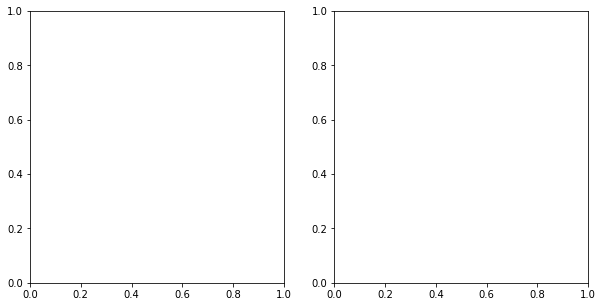

In [33]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, centers, 2, ["Inhibitor", "AKTi"], "Cluster", hue_scores="AKTi")